In [1]:
# Implementation of Gradient boosting trees

import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import json
import pandas as pd
from sklearn.svm import SVC  
import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import boto3
from boto.s3.key import Key
import timeit
from io import StringIO
from sklearn.ensemble import GradientBoostingClassifier 
import seaborn as sns
from sklearn.cross_validation import KFold

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

bucket_name = 'masidorov.cs229.ner'
data_file_name = 'all-items-2sets.json'

#Usage: https://rcarneva.github.io/understanding-gradient-boosting-part-1.html


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

# See bucket API: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Bucket.Object

data_lines = []
obj = bucket.Object(data_file_name)
body = obj.get()['Body'].read().splitlines()
data_lines = body
print(len(data_lines))

INDEX_ID = 0
INDEX_TAGGED = 1
INDEX_TEXT = 2
INDEX_ANNOTATION = 3

# Annotation constants
ANNOTATION_LABEL = 0
ANNOTATION_TEXT = 1
ANNOTATION_POINTS = 2

ANNOTATION_POINTS_START = 1
ANNOTATION_POINTS_STOP = 2

# structure we do support:
# (tagged, text, annotations)
# annotations = [annotation]
# annotation := (label, text, start, stop)
contents = []

id = 0
for line in data_lines:
    dat = json.loads(line)
    content = dat["content"]
    tuple_annotations = []
    annotations = dat["annotation"]
    tagged = False
    if (annotations is not None):
        tagged = True
        for annotation in annotations:
            label = annotation["label"][0]
            points = annotation["points"]
            tuple_annotation = (label)
            
            tuple_points = []
            for point in points:
                text = point["text"]
                start = point["start"]
                stop = point["end"]
                tuple_points.append((text, start, stop))
            tuple_annotations.append((label,text, tuple_points))
    contents.append((id, tagged, content, tuple_annotations))
    id = id + 1
    
    
#DEDUPLICATION
content2tag = {}
for tuple in contents:
    tagged = tuple[INDEX_TAGGED]
    text = tuple[INDEX_TEXT]
    if text not in content2tag.keys():
        content2tag[text] = tagged
    if (not content2tag[text]) and tagged:
        content2tag[text] = tagged
        
visited = {}
dedupe_context = []
for tuple in contents:
    tagged = tuple[INDEX_TAGGED]
    text = tuple[INDEX_TEXT]
    
    if text in visited.keys():
        continue
    
    if (content2tag[text] == tagged):
        visited[text] = True
        dedupe_context.append(tuple)
        
print("Before dedupe=", len(contents), "After dedupe=", len(dedupe_context))
contents = dedupe_context

8163
Before dedupe= 8163 After dedupe= 3914


In [3]:
# Now we create 2 lists for analysis per each record 
# word list: [w1,w2,...]
# tagging: [tag1, tag2,...] we assume that we have 1 tag per word
# Method we iterate via contents, for each line:
# 1) Extract text and extract intervals
# 2) scan in text words and for each word try to find start match in annotation list

# CONSTANTS WE USE
TUPLE_ID = 0
TUPLE_TAGGED_ID = 1
TUPLE_WORD_LIST = 2
TUPLE_TAG_LIST = 3

# Extraction of the tagged entities
def find_tag(start, stop, annotations):
    for annotation in annotations:
        points = annotation[ANNOTATION_POINTS]
        #print("Annot=", points)
        point = points[0]
        astart = point[ANNOTATION_POINTS_START]
        astop = point[ANNOTATION_POINTS_STOP]
        
        if (start == astart):
            return annotation[ANNOTATION_LABEL]
        
    return ""
    

# This function is doing a data processing
def process_tuple(content):
    id = content[INDEX_ID]
    tagged = content[INDEX_TAGGED]
    text = content[INDEX_TEXT]
    
    words = []
    tags = []
    
    annotations = content[INDEX_ANNOTATION]
    start = 0
    stop = 0
    for i in range(len(text) + 1):
        if (i == len(text)) or text[i] == ' ':
            stop = i
            wlen = stop - start
            
            if wlen > 0:
                tag = find_tag(start, stop, annotations)
                words.append(text[start:stop])
                tags.append(tag)

            start = stop + 1
    
    return (id, tagged, words, tags)


# We investigate the structure of ptuple and ann
# price like "under $300"
# price like "$300 after discount"
# "item under discount" item "for $300"
def augment_tuple(ptuple):
    
    return ptuple

pcontents = [process_tuple(content) for content in contents]



print(len(pcontents))

3914


In [4]:
# "item under discount" item "for $300"
def augment_tuple(ptuple, id):
    tagged = ptuple[INDEX_TAGGED]    
    return [(id, tagged, ptuple[TUPLE_WORD_LIST], ptuple[TUPLE_TAG_LIST])]


# Create training and dev set
ROW_TAGGED = len( [x for x in pcontents if x[INDEX_TAGGED] == True])
tagged_set = [x for x in pcontents if x[INDEX_TAGGED] == True]
train_set_index= np.random.choice(ROW_TAGGED, size=int(ROW_TAGGED*0.95), replace=False)

dev_set_index = list(set(range(ROW_TAGGED)) - set(train_set_index))
train_set = [tagged_set[i] for i in train_set_index]
dev_set = [tagged_set[i] for i in dev_set_index]


train_pcontents = []
id = 1
for pcontent in train_set:
    tuples = augment_tuple(pcontent, id)
    id = id + len(tuples)
    train_pcontents = train_pcontents + tuples


dev_pcontents = []
for pcontent in dev_set:
    tuples = augment_tuple(pcontent, id)
    id = id + len(tuples)
    dev_pcontents = dev_pcontents + tuples
    


#print(len(pcontents),len(ppcontents))
train_set = train_pcontents
dev_set = dev_pcontents

print('Train set size=', len(train_set), ' Dev set size=', len(dev_set))

Train set size= 1665  Dev set size= 88


In [5]:
# Definition of the features extraction

class FeatureExtractor:
    def __init__(self, name):
        self.name = name
        
    # sentense tuple is the result of process_tuple
    # we extract features from tuple and return feature value in format
    # (true/false, FeatureName, FeatureValue)
    def extract(self, word_id, sentense_tupe, addition_mode):
        pass
    
    # Return list of features supported by current features extractor
    def features_list(self):
        return [self.name]

# Check if Hypen is inside
class FE_HyphenInside(FeatureExtractor):
    def __init__(self):
        super(FE_HyphenInside, self).__init__('HyphenInside')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        return (True, self.name, '-' in word)


# Check if Hypen is inside
class FE_IsNumber(FeatureExtractor):
    def __init__(self):
        super(FE_IsNumber, self).__init__('IsNumber')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        return (True, self.name, word.isdigit())

# Check started with dollar decimal/ended with dollar
class FE_StartedDollar(FeatureExtractor):
    def __init__(self):
        super(FE_StartedDollar, self).__init__('StartedDollar')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        dollar =  len(word) > 0 and '$' == word[0] 
        return (True, self.name, dollar)


# Check started digit
class FE_StartedDigit(FeatureExtractor):
    def __init__(self):
        super(FE_StartedDigit, self).__init__('StartedDigit')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        digit =  len(word) > 0 and '9' >= word[0] and '0' <= word[0] 
        return (True, self.name, digit)

# Check end digit
class FE_EndDigit(FeatureExtractor):
    def __init__(self):
        super(FE_EndDigit, self).__init__('EndDigit')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        ll = len(word)
        digit =  ll > 0 and '9' >= word[ll-1] and '0' <= word[ll-1] 
        return (True, self.name, digit)


# True if no letters included
class FE_DoesNotHaveLetters(FeatureExtractor):
    def __init__(self):
        super(FE_DoesNotHaveLetters, self).__init__('NoLetters')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        for c in word:
            if c >= 'a' and c <= 'z':
                return (True, self.name, False)
            if c >= 'A' and c <= 'Z':
                return (True, self.name, False)
            
        return (True, self.name, True)


# Word position
class FE_WordPos(FeatureExtractor):
    def __init__(self):
        super(FE_WordPos, self).__init__('WordPosition')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        return (True, self.name, word_id)


# and before
class FE_And_Pos_M1(FeatureExtractor):
    def __init__(self):
        super(FE_And_Pos_M1, self).__init__('And_Pos_M1')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        andBefore = False
        if word_id > 0:
            word = sentense_tupe[TUPLE_WORD_LIST][word_id - 1]
            andBefore = ('and' == word)                        
        return (True, self.name, andBefore)

# and after
class FE_And_Pos_P1(FeatureExtractor):
    def __init__(self):
        super(FE_And_Pos_P1, self).__init__('And_Pos_P1')
        
    def extract(self, word_id, sentense_tupe, addition_mode):
        andAfter = False
        if word_id + 1< len(sentense_tupe[TUPLE_WORD_LIST]):
            word = sentense_tupe[TUPLE_WORD_LIST][word_id + 1]
            andAfter = ('and' == word)                        
        return (True, self.name, andAfter)


# Represent the current word itself
class FE_W0(FeatureExtractor):
    def __init__(self):
        super(FE_W0, self).__init__('W0_')
        self.word2index = {}
        self.current_index = int(0)

    def extract(self, word_id, sentense_tupe, addition_mode):
        word = sentense_tupe[TUPLE_WORD_LIST][word_id]
        if word not in self.word2index.keys():
            if not addition_mode:
                return (False, self.name, 0)
            self.word2index[word] = self.current_index
            self.current_index = int(self.current_index + 1)
        return (True, self.name+str(self.word2index[word]), 1)
    
    def features_list(self):
        return [self.name + str(i) for i in range(self.current_index)]
    


# Class which contains feature extractors we would like to apply
class FeatureExtractionContainer:
    def __init__(self):
        self.feature_extractors = [FE_HyphenInside(), FE_IsNumber(), 
                                   FE_W0(), FE_StartedDollar(), FE_DoesNotHaveLetters(),
                                   FE_StartedDigit(), FE_EndDigit(), FE_WordPos(),
                                   FE_And_Pos_M1(), FE_And_Pos_P1()]

    # This is extraction from one specific tuple
    def extract_from_tuple(self, word_id, sentense_tuple, addition_mode):
        features = {}
        for fe in self.feature_extractors:
            fe_result = fe.extract(word_id, sentense_tuple, addition_mode)
            if fe_result[0]:
                features[fe_result[1]] = fe_result[2]
        return features
    
    # result is a list of tuples which will include
    # word_features_list := (tuple_id, IS_TAGGED, word, word_id, tag, features)
    def process_sentense(self, sentense_tuple, addition_mode):
        result = []
        tuple_id = sentense_tuple[TUPLE_ID]
        tagged = sentense_tuple[TUPLE_TAGGED_ID]
        
        
        for word_id in range(len(sentense_tuple[TUPLE_WORD_LIST])):
            features = self.extract_from_tuple(word_id, sentense_tuple, addition_mode)
            tag = sentense_tuple[TUPLE_TAG_LIST][word_id]
            result.append( (tuple_id, tagged, sentense_tuple[TUPLE_WORD_LIST][word_id], word_id, tag, features) )
            
        return result

    # result is a list of tuples which will include
    # word_features_list := (tuple_id, IS_TAGGED, word, word_id, tag, features)
    def process_sentenses(self, sentense_tuples, addition_mode=True):
        result = []
        for sentense in sentense_tuples:
            result = result + self.process_sentense(sentense, addition_mode)
            
        return result
        
    # This function takes list of tuples produced by
    # process_sentense and put it in nice pandas.DataFrame
    def features_pandalizer(self, word_features_list):
        features_vector = {}
        features_vector['TupleID'] = []
        features_vector['Tagged'] = []
        features_vector['Tag'] = []
        features_vector['word'] = []
        features_vector['WordID'] = []
        
        # Inject features
        for fe in self.feature_extractors:
            for fname in fe.features_list():
                features_vector[fname] = []
        
        # Phase of creating long lists
        for word_features in word_features_list:
            features_vector['TupleID'].append(word_features[0])
            features_vector['Tagged'].append(word_features[1])
            features_vector['Tag'].append(word_features[4])
            features_vector['word'].append(word_features[2])
            features_vector['WordID'].append(word_features[3])
            
            # working with features
            for fe in self.feature_extractors:
                for fname in fe.features_list():
                    if fname in word_features[5].keys():
                        #print('FName=', fname, ' Value=', word_features[5][fname])
                        features_vector[fname].append(int(word_features[5][fname]))
                    else:
                        features_vector[fname].append( 0)
                        
            #print(features_vector)
                        
                        
            
        
        df = pd.DataFrame(features_vector)
        return df
    
    
    
        
#DEBUGGING
print(pcontents[0])
fec= FeatureExtractionContainer()
#all_features= fec.process_sentenses(pcontents)
#print(all_features)
#df = fec.features_pandalizer(all_features)
#print(df.head())


(0, True, ['apple', 'watch'], ['Brand', 'Category'])


In [6]:
%%time
# do split traint/dev set
# count of rows which

fex = FE_W0()
fec= FeatureExtractionContainer()

#print(pcontents[101], fex.extract(0, pcontents[101], False))

#tid = 102
#print(pcontents[tid])

#all_features= fec.process_sentenses(pcontents[101:102], False)

#df = fec.features_pandalizer(all_features)
#print(df.head())

# Arrange trainig and test set



fec= FeatureExtractionContainer()
train_set_feature= fec.process_sentenses(train_set)
dev_set_feature= fec.process_sentenses(dev_set, False)



df_train = fec.features_pandalizer(train_set_feature)

df_dev = fec.features_pandalizer(dev_set_feature)



CPU times: user 4.15 s, sys: 152 ms, total: 4.3 s
Wall time: 4.3 s


In [19]:
%%time


all_labels = ['Brand', 'Category', 'ModelName', '']
cls_per_ner = {}

df_train_result = df_train.loc[:, ['TupleID', 'word','Tag']].copy()
df_train_result = df_train_result.reindex(columns=df_train_result.columns.tolist() + all_labels)

#GBM parameters


stage_preds = {}
final_preds = {}

depth = 3
lr = 0.5
estimators = [300,400,500,600,700,800]
est = 500

#all_labels = [ 'Category']
for label in all_labels:
    #df.head()
    print('Start label = ', label)
    common_args2 = {'max_depth': depth, 'n_estimators': est, 'subsample': 0.9, 'random_state': 2}
    model  = GradientBoostingClassifier(learning_rate=lr, **common_args2)

    df_train_copy = df_train.loc[:].copy()
    df_train_copy['Y'] = df_train_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)

    df_train_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)
    #df1.head()

    X_train = df_train_copy.drop('Y', axis=1)
    Y_train = df_train_copy['Y']

    #svc = SVC(kernel='rbf', gamma=0.7, probability=True)
    #kf = KFold(n_splits = 5, shuffle = True, random_state= 0)
    clf = model.fit(X_train, Y_train)
    cls_per_ner[label] = clf
          
    y_pred = clf.predict(X_train)
    y_pred_porbability = clf.predict_proba(X_train)
    df_train_result[label] = y_pred_porbability[:,1]
    cls_per_ner[label] = clf

    #print("Accuracy:",metrics.accuracy_score(Y_train, y_pred), metrics.precision_score(Y_train, y_pred))
    print(confusion_matrix(Y_train, y_pred))

    print(classification_report(Y_train, y_pred))

csv_buffer = StringIO()
df_train_result.to_csv(csv_buffer)
s3.Object(bucket_name, 'train_gbt_result-small.csv').put(Body=csv_buffer.getvalue())


#DEV set

df_dev_result = df_dev.loc[:, ['TupleID', 'word','Tag']].copy()
df_dev_result['TagPred'] = ''
df_dev_result = df_dev_result.reindex(columns=df_dev_result.columns.tolist() + all_labels)
          
for label in all_labels:
              # Training error
    df_dev_copy = df_dev.copy()
    df_dev_copy['Y'] = df_dev_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
    df_dev_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)

    X_dev = df_dev_copy.drop('Y', axis=1)
    Y_dev = df_dev_copy['Y']

    clf = cls_per_ner[label]
    y_pred = clf.predict(X_dev)
    y_pred_porbability = clf.predict_proba(X_dev)
    df_dev_result[label] = y_pred_porbability[:,1]          

    print('==========================')
    print('Label=', label)
    print('==========================')
    #print("Accuracy:",metrics.accuracy_score(Y_dev, y_pred), "Detemined brands=", np.sum(y_pred), np.sum(Y_dev))
    #print("Accuracy:",metrics.accuracy_score(Y_dev, y_pred), metrics.recall_score(Y_dev, y_pred))
    print(confusion_matrix(Y_dev, y_pred))
    print(classification_report(Y_dev, y_pred))

csv_buffer = StringIO()
df_dev_result.to_csv(csv_buffer)
s3.Object(bucket_name, 'dev_gbm_result-small.csv').put(Body=csv_buffer.getvalue())


Start label =  Brand
[[3253   71]
 [ 207  394]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      3324
          1       0.85      0.66      0.74       601

avg / total       0.93      0.93      0.93      3925

Start label =  Category
[[2527  188]
 [ 198 1012]]
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      2715
          1       0.84      0.84      0.84      1210

avg / total       0.90      0.90      0.90      3925

Start label =  ModelName
[[2885  129]
 [ 163  748]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.95      3014
          1       0.85      0.82      0.84       911

avg / total       0.92      0.93      0.93      3925

Start label =  
[[2865  129]
 [ 458  473]]
             precision    recall  f1-score   support

          0       0.86      0.96      0.91      2994
          1       0.79      0.51      0.62       931



In [88]:
#len(df_dev[['TupleID', 'word']]))
#len(Y_dev)
df_dev_est = df_dev[['TupleID', 'word', 'Tag']]
df_dev_est['TagPred'] = y_pred

df_dev_est.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TupleID,word,Tag,TagPred
0,1578,sony,Brand,0
1,1578,xb50bs,ModelName,1
2,1578,extra,,0
3,1578,bass,,0
4,1579,hp,Brand,0


In [24]:
label = 'ModelName'
df_dev_copy = df_dev.copy()
df_dev_copy['Y'] = df_dev_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
df_dev_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)

X_dev = df_dev_copy.drop('Y', axis=1)
Y_dev = df_dev_copy['Y']

clf = cls_per_ner[label]
y_pred = clf.predict(X_dev)
y_pred_porbability = clf.predict_proba(X_dev)
df_dev_result[label] = y_pred_porbability[:,1]          


In [90]:
df_dev_result['TagPred'] = ''

In [25]:
prob_threshold = 0.4
def calc_tag(row):
    maxi = np.argmax([row[name] for name in all_labels])
    maxval = row[all_labels[maxi]]
    if prob_threshold < maxval:
        return all_labels[maxi]
    return ''
    
    
df_dev_result['TagPred']=df_dev_result.apply(calc_tag, axis=1)
df_dev_result.head(20)

# collect results in list of lists
list_tag = []
list_tag_pred = []
list_list_tag_pred = []
list_list_tag = []
prev_tuple = -1
for index, row in df_dev_result.iterrows():
    tupleId = row['TupleID']
    tag = row['Tag']
    tag_pred = row['TagPred']
    if len(list_tag) > 0 and prev_tuple != tupleId:
        list_list_tag.append(list_tag)
        list_list_tag_pred.append(list_tag_pred)
        list_tag = []
        list_tag_pred = []
    list_tag.append(tag)
    list_tag_pred.append(tag_pred)
    prev_tuple = tupleId
list_list_tag.append(list_tag)
list_list_tag_pred.append(list_tag_pred)
    
#print(list_list_tag)
print(metrics.flat_classification_report(
    list_list_tag, list_list_tag_pred, labels=all_labels, digits=3
))


             precision    recall  f1-score   support

      Brand      0.793     0.697     0.742        33
   Category      0.632     0.606     0.619        71
  ModelName      0.727     0.480     0.578        50
                 0.398     0.649     0.493        57

avg / total      0.617     0.602     0.595       211



In [23]:
sklearn.metrics.confusion_matrix(df_dev_result['Tag'], df_dev_result['TagPred'], labels=all_labels)

array([[23,  1,  1,  8],
       [ 1, 43,  3, 24],
       [ 2,  7, 24, 17],
       [ 3, 14,  3, 37]])

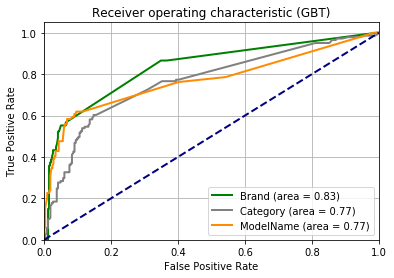

In [17]:
fpr = {}
tpr = {}
roc_auc = {}
colors = {'Brand' : 'green', 'ModelName' : 'darkorange', 'Category' : 'grey'}
for label in all_labels:
    fpr[label], tpr[label], _ = sklearn.metrics.roc_curve(y_true=list((df_dev_result['Tag'] == label).astype(int)), 
                                  y_score=df_dev_result[label].astype(float), pos_label=1)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure()
lw = 2
for label in all_labels:
    plt.plot(fpr[label], tpr[label], color=colors[label],
             lw=lw, label='%s (area = %0.2f)' % (label,roc_auc[label]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (GBT)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [125]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
from sklearn.model_selection import cross_validate
label = 'Category'
print('Start label = ', label)
common_args2 = {'max_depth': depth, 'n_estimators': est, 'subsample': 0.9, 'random_state': 2}
model  = GradientBoostingClassifier(learning_rate=lr, **common_args2)

df_train_copy = df_train.loc[:].copy()
df_train_copy['Y'] = df_train_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)

df_train_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)
#df1.head()

X_train = df_train_copy.drop('Y', axis=1)
Y_train = df_train_copy['Y']

#svc = SVC(kernel='rbf', gamma=0.7, probability=True)
cv_results = cross_validate(model, X_train, Y_train, cv=3, scoring='recall', return_train_score=True, return_estimator=True)


Start label =  Category


TypeError: cross_validate() got an unexpected keyword argument 'return_estimator'

In [34]:
df_dev_result = df_dev_result.rename(columns={'':'None'})
df_dev_result.replace(to_replace='', value='None')

,TupleID,word,Tag,TagPred,Brand,Category,ModelName,None
0,1666,ipad,ModelName,ModelName,0.163666,9.191271e-02,0.779611,0.071780
1,1667,hp,Brand,Brand,0.776242,5.093781e-02,0.066650,0.071780
2,1667,"27""",ScreenSize,None,0.021545,4.624442e-02,0.066650,0.161258
3,1667,ips,None,None,0.021545,1.535602e-01,0.041976,0.663453
4,1667,led,None,None,0.021545,1.298288e-01,0.041976,0.673207
5,1667,fhd,None,None,0.021545,1.298288e-01,0.041976,0.324960
6,1667,monitor,None,Category,0.021545,7.457812e-01,0.041976,0.182234
7,1668,apple,Brand,Brand,0.751999,9.191271e-02,0.066650,0.071780
8,1668,tv,Category,Category,0.021545,8.624945e-01,0.066650,0.088241
9,1669,asus,Brand,Brand,0.756061,9.191271e-02,0.066650,0.071780


In [33]:
df_dev_result.head(10)

,TupleID,word,Tag,TagPred,Brand,Category,ModelName,None
0,1666,ipad,ModelName,ModelName,0.163666,0.091913,0.779611,0.071780
1,1667,hp,Brand,Brand,0.776242,0.050938,0.066650,0.071780
2,1667,"27""",ScreenSize,,0.021545,0.046244,0.066650,0.161258
3,1667,ips,,,0.021545,0.153560,0.041976,0.663453
4,1667,led,,,0.021545,0.129829,0.041976,0.673207
5,1667,fhd,,,0.021545,0.129829,0.041976,0.324960
6,1667,monitor,,Category,0.021545,0.745781,0.041976,0.182234
7,1668,apple,Brand,Brand,0.751999,0.091913,0.066650,0.071780
8,1668,tv,Category,Category,0.021545,0.862495,0.066650,0.088241
9,1669,asus,Brand,Brand,0.756061,0.091913,0.066650,0.071780
